In [17]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import h5py
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from  keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential

In [12]:
D=[]
check=[]
label = []
for folder in ["128_7ms/ok","128_7ms/nok"]:
    i = 0
    for file in os.listdir(folder):
        if(i>900):
            continue
        if(".npy" in file):
            spectogram = np.load(folder+"/"+file)
            if spectogram.shape != (128, 128): continue
            D.append((spectogram, folder))
            label.append(folder)
            check.append(spectogram) #może tu normalizować
            i+=1
print(len(D),len(D[0]),"done")

1096 2 done


In [3]:
def normalization(data,x_max,x_min):
    diff = x_max-x_min
    for rows in range(0,len(data)):
        for cols in range(0,len(data[0])):
            data[rows][cols] = (data[rows][cols]-x_min)/diff 
    return data

In [13]:
dataset_min = np.amin(check)
dataset_max = np.amax(check) #jak teraz znormalizuje to jak potem to zrobić?
print(dataset_min,dataset_max)
dataset_normalized = []
for data in D:
    dataset_normalized.append([normalization(data[0],dataset_max,dataset_min),data[1]])

7.295001191662265e-14 0.0006509951221093928


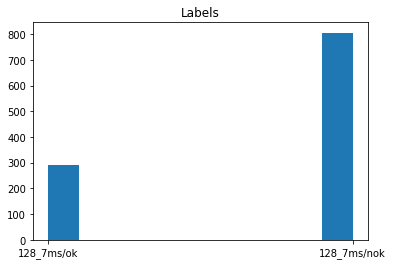

In [14]:
plt.hist(label)  # arguments are passed to np.histogram
plt.title("Labels")
plt.show()

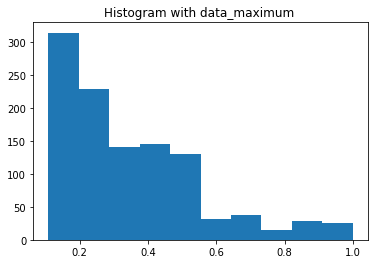

In [15]:
plt.hist([np.amax(data_x[0]) for data_x in dataset_normalized])  # arguments are passed to np.histogram
plt.title("Histogram with data_maximum ")
plt.show()

In [7]:
dataset_array = keras.utils.normalize(check,axis=-1,order=2)
dataset = dataset_normalized

print(len(D))
print(len(D[0]))
print(len(D[0][0]))
print(len(D[0][0][0]))
random.shuffle(dataset)

train = dataset[:550]
test = dataset[550:]

x_train, y_train = zip(*train)
x_test, y_test = zip(*test)

# Reshape for CNN input
x_train = np.array([x.reshape( (128, 128, 1) ) for x in x_train])
x_test = np.array([x.reshape( (128, 128, 1) ) for x in x_test])

# One-Hot encoding for classes
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
print(y_test)

592
2
128
128
[0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0
 0 1 1 0 0]


In [8]:
Tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', write_images=True)
filepath="weights-improvement.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor="acc", verbose=1, save_best_only=True)
callbacks_list = [checkpoint,Tensor_board]

In [ ]:
#architekrura 128x32
model = Sequential()
input_shape=(128, 32, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

In [9]:
#architektura 128x128
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

In [10]:
optimazerAdam = keras.optimizers.Adam(lr=0.0001, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['acc'])#accuracy

history = model.fit(x_train, y_train,
          epochs=25,
          batch_size=128,
          callbacks = callbacks_list)

score = model.evaluate(x_test, y_test, batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
## tensorboard --logdir C:\Users\Jakub\praca_inzynierska\Scissors_falling\logs --port=8080

Epoch 1/25
550/550 [==============================] - 29s 53ms/step - loss: 0.6937 - acc: 0.5309

Epoch 00001: acc improved from -inf to 0.53091, saving model to weights-improvement.hdf5
Epoch 2/25
550/550 [==============================] - 34s 61ms/step - loss: 0.6948 - acc: 0.4927

Epoch 00002: acc did not improve from 0.53091
Epoch 3/25
550/550 [==============================] - 30s 55ms/step - loss: 0.6941 - acc: 0.4764

Epoch 00003: acc did not improve from 0.53091
Epoch 4/25
550/550 [==============================] - 31s 56ms/step - loss: 0.6926 - acc: 0.5255

Epoch 00004: acc did not improve from 0.53091
Epoch 5/25
550/550 [==============================] - 32s 58ms/step - loss: 0.6925 - acc: 0.4927

Epoch 00005: acc did not improve from 0.53091
Epoch 6/25
550/550 [==============================] - 33s 59ms/step - loss: 0.6914 - acc: 0.4855

Epoch 00006: acc did not improve from 0.53091
Epoch 7/25
550/550 [==============================] - 34s 62ms/step - loss: 0.6911 - acc: 0.4

In [ ]:
print(history.history)

In [ ]:
model.save_weights("model_128_7ms.h5")
print("Saved model to disk")

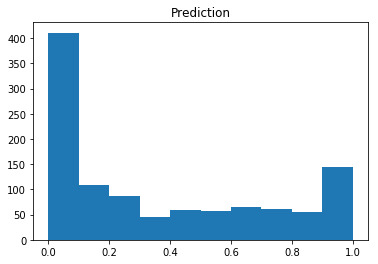

[[643 162]
 [ 68 223]]


In [31]:
prediction = []
prediction_label =[]
prediction_predicted = []
for check_item in dataset_normalized:
    prediction.append(model.predict(check_item[0].reshape(1,128,128,1))[0][0])
    prediction_label.append(check_item[1])
    if(prediction[-1]>0.5):
        prediction_predicted.append("128_7ms/ok")
    else:
        prediction_predicted.append("128_7ms/nok")
plt.hist(prediction)  # arguments are passed to np.histogram
plt.title("Prediction")
plt.show()
matrix = confusion_matrix(y_pred=prediction_predicted,y_true=prediction_label)
print(matrix)